In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from slicer_generation import *

from surface_solns import *
from custom_slicer_helpers import *

In [2]:
%matplotlib ipympl

In [2]:
def make_sample_txt(p, fn_out="custom_mirror_array_params_0.txt"):
    """Make a sample txt file for loading slice parameters.
    
    Parameters
    ----------
    p: ImageSliceParams
        Parameter file to use to create the sample txt file.
    fn_out: str
        Filename to write the sample txt file to.

    Returns
    -------
    arr:

    """
    f = open(fn_out, "w")
    n_slices_per_col = p.n_each * p.n_rows
    f.write(f"{n_slices_per_col} {p.n_cols} {p.cylinder}\n")
    f.write(f"{p.dx} {p.dy} {p.gx_width} {p.gx_depth} {p.gy_width} {p.gy_depth}\n")

    for col_num in range(p.n_cols):
        for slice_num in range(n_slices_per_col):
            alpha, beta, gamma, c, k = get_slice_params_standard(slice_num, col_num, p)
            f.write(f"{alpha} {beta} {gamma} {c} {k}\n")
    f.close()
#make_sample_txt(p)

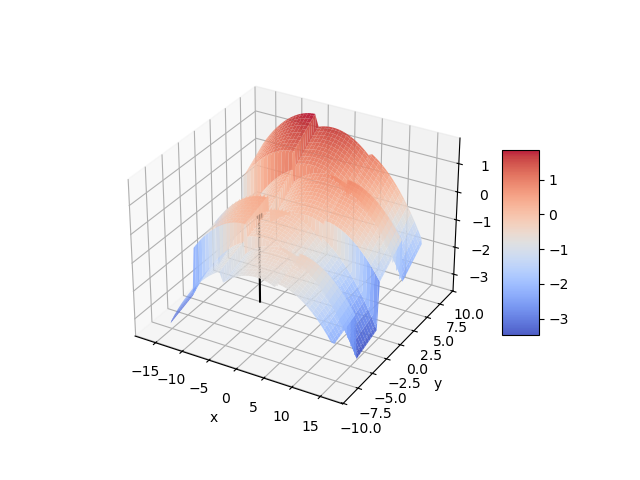

In [16]:
xsize, ysize = get_slicer_size(p)

N = 300

x = np.linspace(1.1*(-xsize/2 + umin),1.1*(xsize/2 + umax),N)
y = np.linspace(-1.1*ysize/2,1.1*ysize/2,N)

Z = np.zeros((N,N))
for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        Z[j,i]=make_image_slicer(x1, y1, p, p_custom)
    

X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.9)

tedge = zmin / ray_in.n

#ax.plot([ray_in.xt, ray_out.xs], [ray_in.yt, ray_out.ys],zs=[0, ray_out.zs], c='k')
ax.plot([ray_in.xt, ray_in.xt + tedge*ray_in.l], [ray_in.yt, ray_in.yt + tedge*ray_in.m],zs=[0, zmin], c='k')
ax.scatter([ray_out.xs], [ray_out.ys], zs=[ray_out.zs], c='k')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(zmin, zmax)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [11]:
plt.close("all")

checking slice solution at ns, nc = 2.0 0.0
RayOut(xs=np.float64(-7.0), ys=np.float64(0.0), zs=np.float64(-0.43853802472963066), t=np.float64(-0.43853802472963066), ln=np.float64(0.15633909671848162), mn=np.float64(0.1884627012563597), nn=np.float64(-0.9695565466090181)) 0.0
analytic soln: -0.43853802472963066
numerical soln:-0.4569138276553115


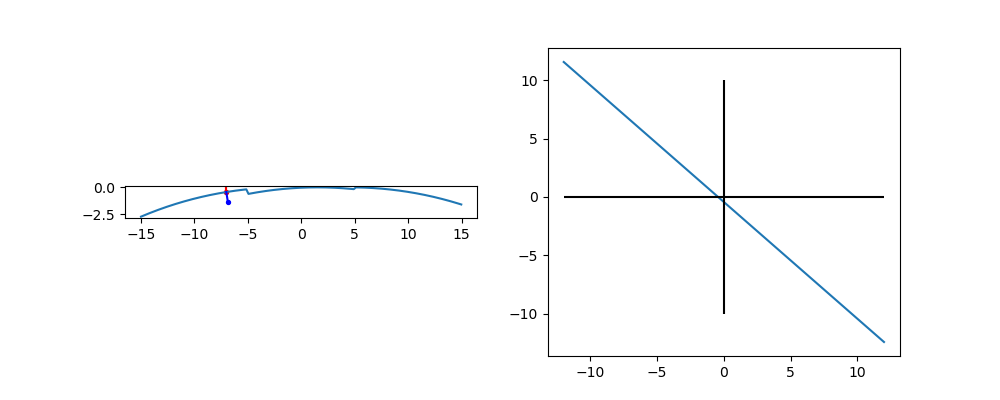

In [14]:
p = ImageSlicerParams(
    custom = False,
    surface_type = 1,
    n_each = 2,
    n_rows = 2,
    n_cols = 3,
    angle_mode = 1,
    dalpha = 6,
    dbeta = -10,
    dgamma = 6,
    gamma_offset = 0,
    dzps = 0,
    dzp_col = 0,
    dzp_row = 0,
    dsyx = 0,
    dsyz = 0,
    dsxy = 0,
    dsxz = 0,
    du = 0,
    alpha_cen = 8,
    beta_cen = -5,
    gamma_cen = 3,
    zps_cen = 0,
    zp_cen = 0,
    syx_cen = 0,
    syz_cen = 0,
    sxy_cen = 0,
    sxz_cen = 0,
    u_cen = 0,
    dx = 10,
    dy = 4,
    c = -1/35,
    k = 0,
    gx_width = 0,
    gx_depth = 2,
    gy_width = 0,
    gy_depth = 1
)

trace_walls = True
p_custom = np.array([])

yt = 0
x = np.linspace(-20, 20, 200)
surf = np.zeros(len(x))
for i,x1 in enumerate(x):
    surf[i] = make_image_slicer(x1, yt, p, p_custom)

xt = -7
l = 0
m = 0
n = 1

norm = np.sqrt(l*l+m*m+n*n)
l /= norm
m /= norm
n /= norm

ray_in = RayIn(xt, yt, 0, l, m, n)

umin, umax = get_min_max_u(p, p_custom)
zmin, zmax = find_global_extrema_slicer(umin, umax, p, p_custom)
ray_out = ray_trace_slicer(ray_in, zmin, zmax, umin, umax, trace_walls, p, p_custom)
print("analytic soln: " + str(ray_out.t))

t = np.linspace(-12, 12, 500)
feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = transfer_function(t1, ray_in, p, p_custom)
idx = np.nanargmin(np.abs(feval))
tnum = t[idx]
print("numerical soln:" + str(tnum))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(x, surf)

# Draw analytically calculated ray and surface normal
axs[0].plot([ray_in.xt, ray_out.xs], [0, ray_out.zs], c='r', zorder=1)
axs[0].scatter([ray_out.xs], [ray_out.zs], c='r', s=8, zorder=1)
axs[0].plot([ray_out.xs, ray_out.xs + ray_out.ln], [ray_out.zs, ray_out.zs + ray_out.nn], c='b')
axs[0].scatter([ray_out.xs + ray_out.ln], [ray_out.zs + ray_out.nn], c='b', s=8, zorder=10)

# Numerically determined ray
axs[0].plot([ray_in.xt, ray_in.xt + tnum*ray_in.l], [0, tnum*ray_in.n], c='gray', zorder=0)
axs[0].scatter([ray_in.xt + tnum*ray_in.l], [tnum*ray_in.n], c='gray', s=8, zorder=0)

axs[0].set_aspect("equal")

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -10, 10, colors='k')
#axs[1].set_ylim(np.nanmin(feval), np.nanmax(feval))

plt.show()

analytic soln: -0.7810249675906653
numerical soln:-0.7935871743486977


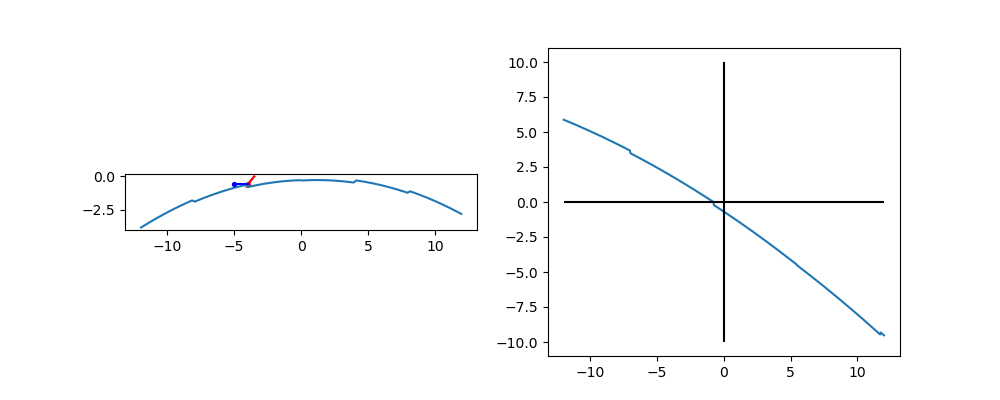

In [4]:
p = ImageSlicerParams(
    custom = 0,
    surface_type = 0,
    n_each = 3,
    n_rows = 2,
    n_cols = 3,
    angle_mode = 0,
    dalpha = 4,
    dbeta = 4,
    dgamma = 10,
    gamma_offset = 0,
    dzps = 0,
    dzp_col = 0,
    dzp_row = 0,
    dsyx = 0,
    dsyz = 0,
    dsxy = 0,
    dsxz = 0,
    du = 0,
    alpha_cen = 5,
    beta_cen = 5,
    gamma_cen = 0,
    zps_cen = 0,
    zp_cen = 0,
    syx_cen = 0,
    syz_cen = 0,
    sxy_cen = 0,
    sxz_cen = 0,
    u_cen = 0,
    dx = 10,
    dy = 4,
    c = -1/20,
    k = -1,
    gx_width = 1,
    gx_depth = -2,
    gy_width = 0,
    gy_depth = 1
)

trace_walls = True
p_custom = np.array([])

xt = 1
y = np.linspace(-20, 20, 200)
surf = np.zeros(len(y))
for i,y1 in enumerate(y):
    surf[i] = make_image_slicer(xt, y1, p, p_custom)


yt = -3.5
l = 0
m = 0.5
n = 0.6
norm = np.sqrt(l*l+m*m+n*n)
l /= norm
m /= norm
n /= norm

ray_in = RayIn(xt, yt, 0, l, m, n)
ray_out = RayOut(0, 0, 0, 0, 0, 0, 0)

umin, umax = get_min_max_u(p, p_custom)
zmin, zmax = find_global_extrema_slicer(umin, umax, p, p_custom)
ray_out = ray_trace_slicer(ray_in, zmin, zmax, umin, umax, trace_walls, p, p_custom)
print("analytic soln: " + str(ray_out.t))

t = np.linspace(-12, 12, 500)
feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = transfer_function(t1, ray_in, p, p_custom)
idx = np.nanargmin(np.abs(feval))
tnum = t[idx]
print("numerical soln:" + str(tnum))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(y, surf)

# Draw analytically calculated ray and surface normal
axs[0].plot([ray_in.yt, ray_out.ys], [0, ray_out.zs], c='r', zorder=1)
axs[0].scatter([ray_out.ys], [ray_out.zs], c='r', s=8, zorder=1)
axs[0].plot([ray_out.ys, ray_out.ys + ray_out.mn], [ray_out.zs, ray_out.zs + ray_out.nn], c='b')
axs[0].scatter([ray_out.ys + ray_out.mn], [ray_out.zs + ray_out.nn], c='b', s=8, zorder=10)

# Numerically determined ray
axs[0].plot([ray_in.yt, ray_in.yt + tnum*ray_in.m], [0, tnum*ray_in.n], c='gray', zorder=0)
axs[0].scatter([ray_in.yt + tnum*ray_in.m], [tnum*ray_in.n], c='gray', s=8, zorder=0)

axs[0].set_aspect("equal")

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -10, 10, colors='k')
#axs[1].set_ylim(np.nanmin(feval), np.nanmax(feval))

plt.show()

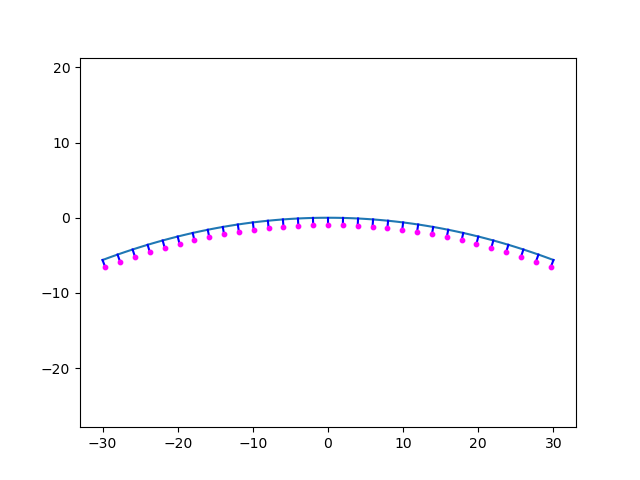

In [5]:
xs = np.linspace(-30,30,100)
c = -1/80
k = -1
alpha = 0
beta = 0
gamma = 0
x0, y0 = conic_2d_off_axis_distance(c, k, alpha, beta)

pslice = SliceParams(
    alpha,
    beta,
    gamma,
    c,
    k,
    zp=0,
    syx=0,
    syz=0,
    sxy=0,
    sxz=0,
    u=0
)

surface = []
for xi in xs:
    surface.append(slice_sag(xi, y0, pslice, conic_2d_transfer, conic_2d_transformation))

plt.figure()
plt.plot(xs, surface)
for xtest in np.arange(-30, 30.1, 2):
    nx, ny, nz = slice_surface_normal(xtest, y0, pslice, conic_2d_transfer, conic_2d_surface_normal, conic_2d_transformation)
    ztest = slice_sag(xtest, y0, pslice, conic_2d_transfer, conic_2d_transformation)
    plt.plot([xtest, xtest+nx], [ztest, ztest+nz], c='b')
    plt.scatter([xtest+nx], [ztest+nz], c='fuchsia', s=10, zorder=10)
    #plt.plot([xtest, xtest-c*xtest], [ztest, ztest+1-c*ztest], c='r')
plt.plot()
plt.axis("equal")
#plt.plot([xtest, xtest-c*xtest], [ztest, ztest+1-c*ztest], c='r')
#plt.ylim(-1,4)
#plt.scatter(xs[idx], surface[idx], c='r')
plt.show()

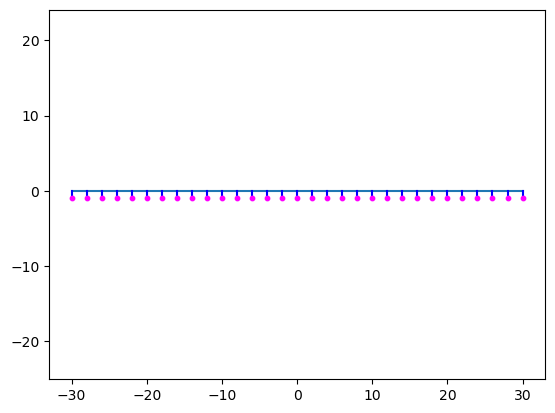

In [ ]:
sag_func = plane_sag
surface_norm_func = plane_surface_normal

ys = np.linspace(-30,30,100)
c = -1/40
k = 0
alpha = 0
beta = 0
gamma = 10
x0, y0 = 0,0

pslice = SliceParams(
    alpha,
    beta,
    gamma,
    c,
    k,
    zp=0,
    syx=0,
    syz=0,
    sxy=0,
    sxz=0,
    u=0
)

surface = sag_func(x0, ys, pslice)

plt.figure()
plt.plot(ys, surface)

for ytest in np.arange(-30, 30.1, 2):
    nx, ny, nz = surface_norm_func(x0, ytest, pslice, normalize=True)
    ztest = sag_func(x0, ytest, pslice)
    plt.plot([ytest, ytest+ny], [ztest, ztest+nz], c='b')
    plt.scatter([ytest+ny], [ztest+nz], c='fuchsia', s=10, zorder=10)
    #plt.plot([ytest, ytest-c*ytest], [ztest, ztest+1-c*ztest], c='r'
plt.axis("equal")
plt.show()

In [5]:
n_each = 1
n_rows = 1
n_cols = 1
mode = 0
trace_walls = True
active_x = False
active_y = False
dalpha = -0
dbeta = 0
dgamma = 0
alpha_cen = 0
beta_cen = 15
gamma_cen = 0
dx = 15
dy = 5
r = 30
c = 1/r
k = -1
gx_width = 0
gx_depth = np.nan
gy_width = 0
gy_depth = np.nan
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_walls, active_x, active_y, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, gx_width, gx_depth, gy_width, gy_depth)

N = 20
r = 20
k = 0
t = -10

y = np.linspace(-8, 8, N)
x = np.linspace(-8, 8, N)
z = conic_3d_sag(x, 0, c, k, alpha_cen, beta_cen, 0)

plt.figure()
plt.scatter(x, z)
plt.show()

TypeError: ImageSlicerParams.__init__() missing 13 required positional arguments: 'syx_cen', 'syz_cen', 'sxy_cen', 'sxz_cen', 'u_cen', 'dx', 'dy', 'c', 'k', 'gx_width', 'gx_depth', 'gy_width', and 'gy_depth'

In [21]:
conic_2d_transformation(np.array([0,0,0]), pslice, 1, True)

array([0., 0., 1.])

In [18]:
conic_2d_transfer(0,0,-1,0,0,1,pslice)

np.float64(1.0)

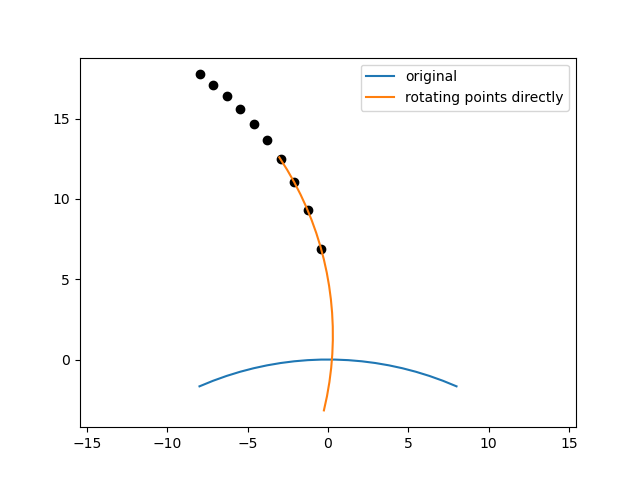

In [12]:
c = -1/20
k = 0

beta = 0
alpha = 0
gamma = 80  # note: gamma is actually counterclockwise but will appear clockwise in plot if x-axis is not flipped... 
zp = 5
ytest = 0

def conic(x,y,c,k,a,b):
    b *= np.pi/180
    a *= np.pi/180
    x0,y0 = conic_2d_off_axis_distance(c,k,a,b)
    x += x0
    y += y0
    return c*(x*x + y*y) / (1 + np.sqrt(1-(1+k)*c*c*(x*x + y*y)))

N = 20

# perform the rotation manually with a rotation matrix
x1 = np.linspace(-8, 8, N)
y1 = []
x2 = []
y2 = []
y3 = []
gammarad = gamma*np.pi/180

syx = 1
syz = 1

pslice = SliceParams(
    alpha,
    beta,
    gamma,
    c,
    k,
    zp=zp,
    syx=0,
    syz=0,
    sxy=0,
    sxz=0,
    u=0
)

for i in range(N):
    y1.append(conic(x1[i],ytest,c,k,alpha,beta))

    # this is counterclockwise rotation of x-z points about the y-axis, but y-axis
    # (middle row of matrix) is not present here
    trans = np.array(
        [
            [np.cos(gammarad), np.sin(gammarad)],
            [-np.sin(gammarad), np.cos(gammarad)] 
        ]
    )
    xnew, ynew = np.dot(trans, [x1[i], y1[i]])
    

    #xnew = x1[i]*np.cos(gammarad)-y1[i]*np.sin(gammarad)
    #ynew = x1[i]*np.sin(gammarad)+y1[i]*np.cos(gammarad)
    
    x2.append(xnew)
    y2.append(ynew + zp)
    y3.append(slice_sag(x1[i], ytest, pslice, conic_2d_transfer, conic_2d_transformation))

plt.figure()
plt.plot(x1,y1,label='original')
plt.plot(x2,y2,label='rotating points directly')
plt.scatter(x1,y3,c='k')
#plt.vlines([-2,0,2], -1, 1)
#plt.ylim(0,8)
#plt.xlim(-8,8)
plt.axis('equal')
plt.legend()
#plt.savefig("rotated_conics.png",dpi=300,facecolor="white")
plt.show()

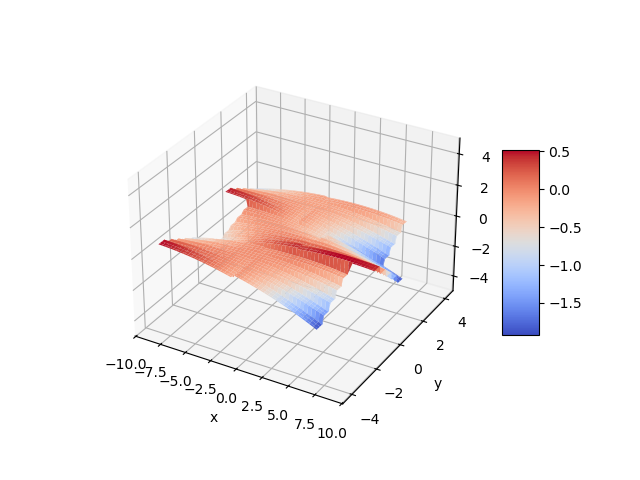

In [8]:
p = ImageSlicerParams(
    custom = 0,
    surface_type = 0,
    n_each = 5,
    n_rows = 3,
    n_cols = 2,
    angle_mode = 2,
    dalpha = -3,
    dbeta = 3,
    dgamma = 3,
    gamma_offset = 1.5,
    dzps = 0,
    dzp_col = 0,
    dzp_row = 0,
    dsyx = 0,
    dsyz = 0,
    dsxy = 0,
    dsxz = 0,
    du = 3,
    alpha_cen = 4,
    beta_cen = -5,
    gamma_cen = 0,
    zp_cen = 0,
    zps_cen = 0,
    syx_cen = 0,
    syz_cen = 0,
    sxy_cen = 0,
    sxz_cen = 0,
    u_cen = 0,
    dx = 8,
    dy = 0.5,
    c = -1/50,
    k =0,
    gx_width = 0,
    gx_depth = -3,
    gy_width = 0,
    gy_depth = 2
)
p_custom = np.array([])
xsize, ysize = get_slicer_size(p)

N = 200

#Nx = n_cols * 8
#Ny = n_rows * n_each * 8
x = np.linspace(-1.1*xsize/2,1.1*xsize/2,N)
y = np.linspace(-1.1*ysize/2,1.1*ysize/2,N)

Z = np.zeros((N,N))
for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        Z[j,i]=make_image_slicer(x1, y1, p, p_custom)
        #Z[i,j]=make_image_slicer2(x1, y1, n_each, dalpha, dbeta, alpha_cen, beta_cen, dx, dy, rx, ry, kx, ky)
    

X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

#zmin, zmax = find_global_extrema_slicer(p, sag_func, critical_xy_func)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
#ax.plot_surface(X,Y,np.ones((N,N))*zmin, alpha=0.3)
#ax.plot_surface(X,Y,np.ones((N,N))*zmax, alpha=0.3)
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(-5, 5)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [4]:
p_custom = load_slice_params_file(1)
p = make_image_slicer_params_from_custom(p_custom)

In [15]:
p = ImageSlicerParams(
    custom = 0,
    surface_type = 0,
    n_each = 5,
    n_rows = 1,
    n_cols = 1,
    angle_mode = 0,
    dalpha = 4,
    dbeta = 4,
    dgamma = 10,
    gamma_offset = 0,
    dzp_col = 0,
    dzp_row = 0,
    dsyx = 0,
    dsyz = 0,
    dsxy = 0,
    dsxz = 0,
    du = 0,
    alpha_cen = 0,
    beta_cen = 0,
    gamma_cen = 0,
    zp_cen = 0,
    syx_cen = 0,
    syz_cen = 0,
    sxy_cen = 0,
    sxz_cen = 0,
    u_cen = 0,
    dx = 10,
    dy = 4,
    c = -1/40,
    k = 0,
    gx_width = 1,
    gx_depth = -2,
    gy_width = 1.5,
    gy_depth = 1
)

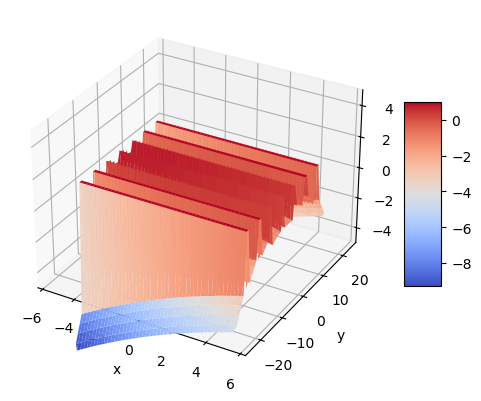

In [17]:
xsize, ysize = get_slicer_size(p)

N = 500

#Nx = n_cols * 8
#Ny = n_rows * n_each * 8
x = np.linspace(-1.1*xsize/2,1.1*xsize/2,N)
y = np.linspace(-1.1*ysize/2,1.1*ysize/2,N)

Z = np.zeros((N,N))
for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        Z[j,i]=make_image_slicer(x1, y1, p, p_custom)
        #Z[i,j]=make_image_slicer2(x1, y1, n_each, dalpha, dbeta, alpha_cen, beta_cen, dx, dy, rx, ry, kx, ky)
    

X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

#zmin, zmax = find_global_extrema_slicer(p, sag_func, critical_xy_func)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
#ax.plot_surface(X,Y,np.ones((N,N))*zmin, alpha=0.3)
#ax.plot_surface(X,Y,np.ones((N,N))*zmax, alpha=0.3)
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(-5, 5)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()